In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose,Reshape

In [2]:
%matplotlib inline

batch_size = 256
original_dim = 784
latent_dim = 8
epochs = 10
epsilon_std = 1.0
noise_factor = 0.5

In [3]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
train_num=50000
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), 28,28,1))
x_test = x_test.reshape((len(x_test), 28,28,1))
noise_train = x_train + noise_factor * np.random.randn(*x_train.shape)
noise_test = x_test + noise_factor * np.random.randn(*x_test.shape)
# Clip the images to be between 0 and 1
noise_train = np.clip(noise_train, 0., 1.)
noise_test = np.clip(noise_test, 0., 1.)

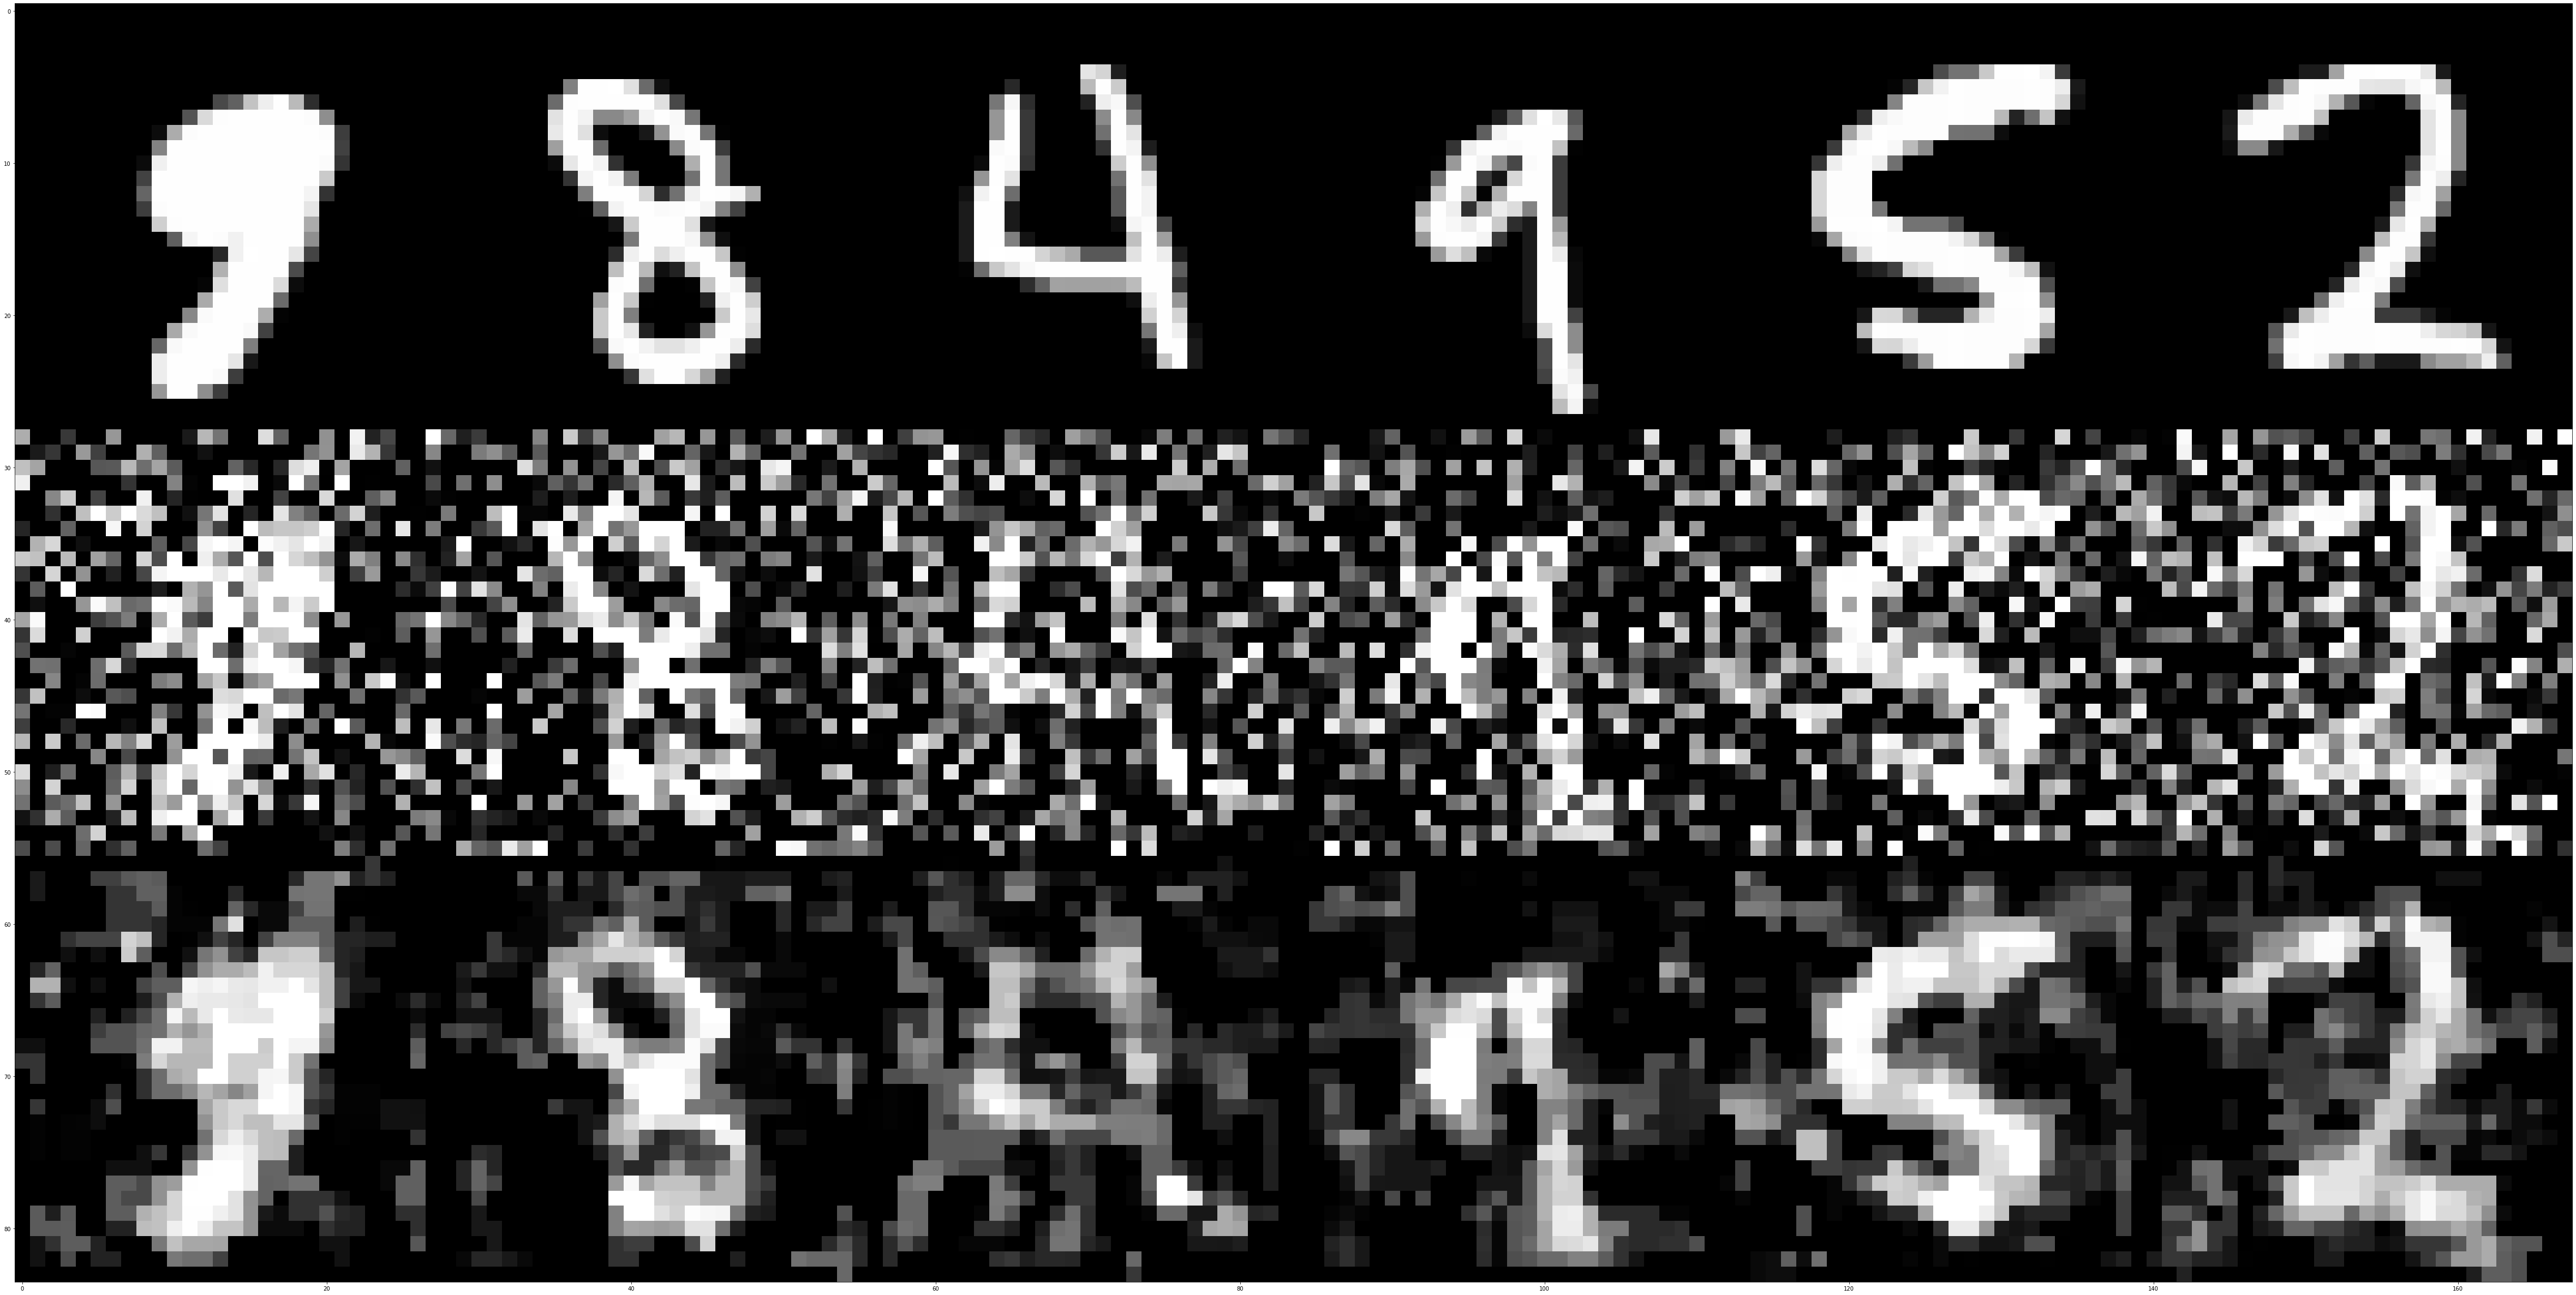

In [4]:
num_train = 50000
n_images = 6
import scipy.signal as signal
figure = np.zeros((28*3 , 28 * n_images))
# Display
showidx=np.random.randint(0,num_train,n_images)
for i,idx in enumerate (showidx):
    figure[0: 28,i *28: (i + 1) * 28] = np.reshape(x_train[idx], [28, 28])
    figure[28: 56,i *28: (i + 1) * 28] = np.reshape(noise_train[idx], [28, 28])
    figure[28 * 2: 28 * 3,i *28: (i + 1) * 28] = signal.medfilt2d(np.reshape(noise_train[idx], [28, 28]),[3,3])

plt.figure(figsize=(28*3, 28*n_images))
plt.imshow(figure, cmap='Greys_r')
plt.show()

In [19]:
#encoder part
x_noise = Input(shape=(28,28,1))
conv_1 = Conv2D(64,(3, 3), padding='valid',activation='relu')(x_noise)
conv_2 = Conv2D(64,(3, 3), padding='valid',activation='relu')(conv_1)
pool_1 = MaxPooling2D((2, 2))(conv_2)
conv_3 = Conv2D(32,(3, 3), padding='valid',activation='relu')(pool_1)
pool_2 = MaxPooling2D((2, 2))(conv_3)
h=Flatten()(pool_2)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

#reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

In [20]:
#decoder part
# we instantiate these layers separately so as to reuse them later
z=Reshape([1,1,latent_dim])(z)
conv_0T = Conv2DTranspose(128,(1, 1), padding='valid',activation='relu')(z)#1*1
conv_1T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_0T)#3*3
conv_2T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_1T)#5*5
conv_3T = Conv2DTranspose(48,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_2T)#10*10
conv_4T = Conv2DTranspose(48,(3, 3), padding='valid',activation='relu')(conv_3T)#12*12
conv_5T = Conv2DTranspose(32,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_4T)#24*24
conv_6T = Conv2DTranspose(16,(3, 3), padding='valid',activation='relu')(conv_5T)#26*26
x_out = Conv2DTranspose(1,(3, 3), padding='valid',activation='sigmoid')(conv_6T)#28*28

# instantiate VAE model
vae = Model(x_noise, x_out)
vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 26, 26, 64)   640         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 24, 24, 64)   36928       conv2d_9[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 12, 12, 64)   0           conv2d_10[0][0]                  
____________________________________________________________________________________________

In [30]:

# xent_loss = original_dim * metrics.binary_crossentropy(x_origin, x_out)
# kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
# vae_loss = K.mean(xent_loss + kl_loss)
# vae.compile(optimizer='adam', loss=VAE_loss)

x_origin=K.flatten(x_noise)
x_out=K.flatten(x_out)
reconstruction_loss = keras.losses.binary_crossentropy(x_origin, x_out)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [7]:
# from keras.utils.vis_utils import plot_model
# plot_model(vae, to_file='model1.png',show_shapes=True)

In [13]:
# reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
# reconstruction_loss *= original_dim
# kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
# kl_loss = K.sum(kl_loss, axis=-1)
# kl_loss *= -0.5
# vae_loss = K.mean(reconstruction_loss + kl_loss)
# vae.add_loss(vae_loss)
# vae.compile(optimizer='adam')

In [37]:
# import keras
# from keras import backend as K

# x_origin=K.flatten(x_origin)
# x_out=K.flatten(x_out)
# reconstruction_loss = keras.losses.binary_crossentropy(x_origin, x_out)
# reconstruction_loss *= original_dim

# kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
# kl_loss = K.sum(kl_loss, axis=-1)
# kl_loss *= -0.5
# vae_loss = K.mean(reconstruction_loss + kl_loss)
# vae.add_loss(vae_loss)
# vae.compile(optimizer='adam')

In [38]:
# from tensorflow.python.framework.ops import disable_eager_execution

# disable_eager_execution()

In [39]:
vae.fit(noise_train,
        x_train,
        shuffle=True,
        epochs=1,
        batch_size=16000,
        validation_data=(noise_test, x_test))

In [33]:
digit_size = 28
figure = np.zeros((digit_size * 4, digit_size * n_images))

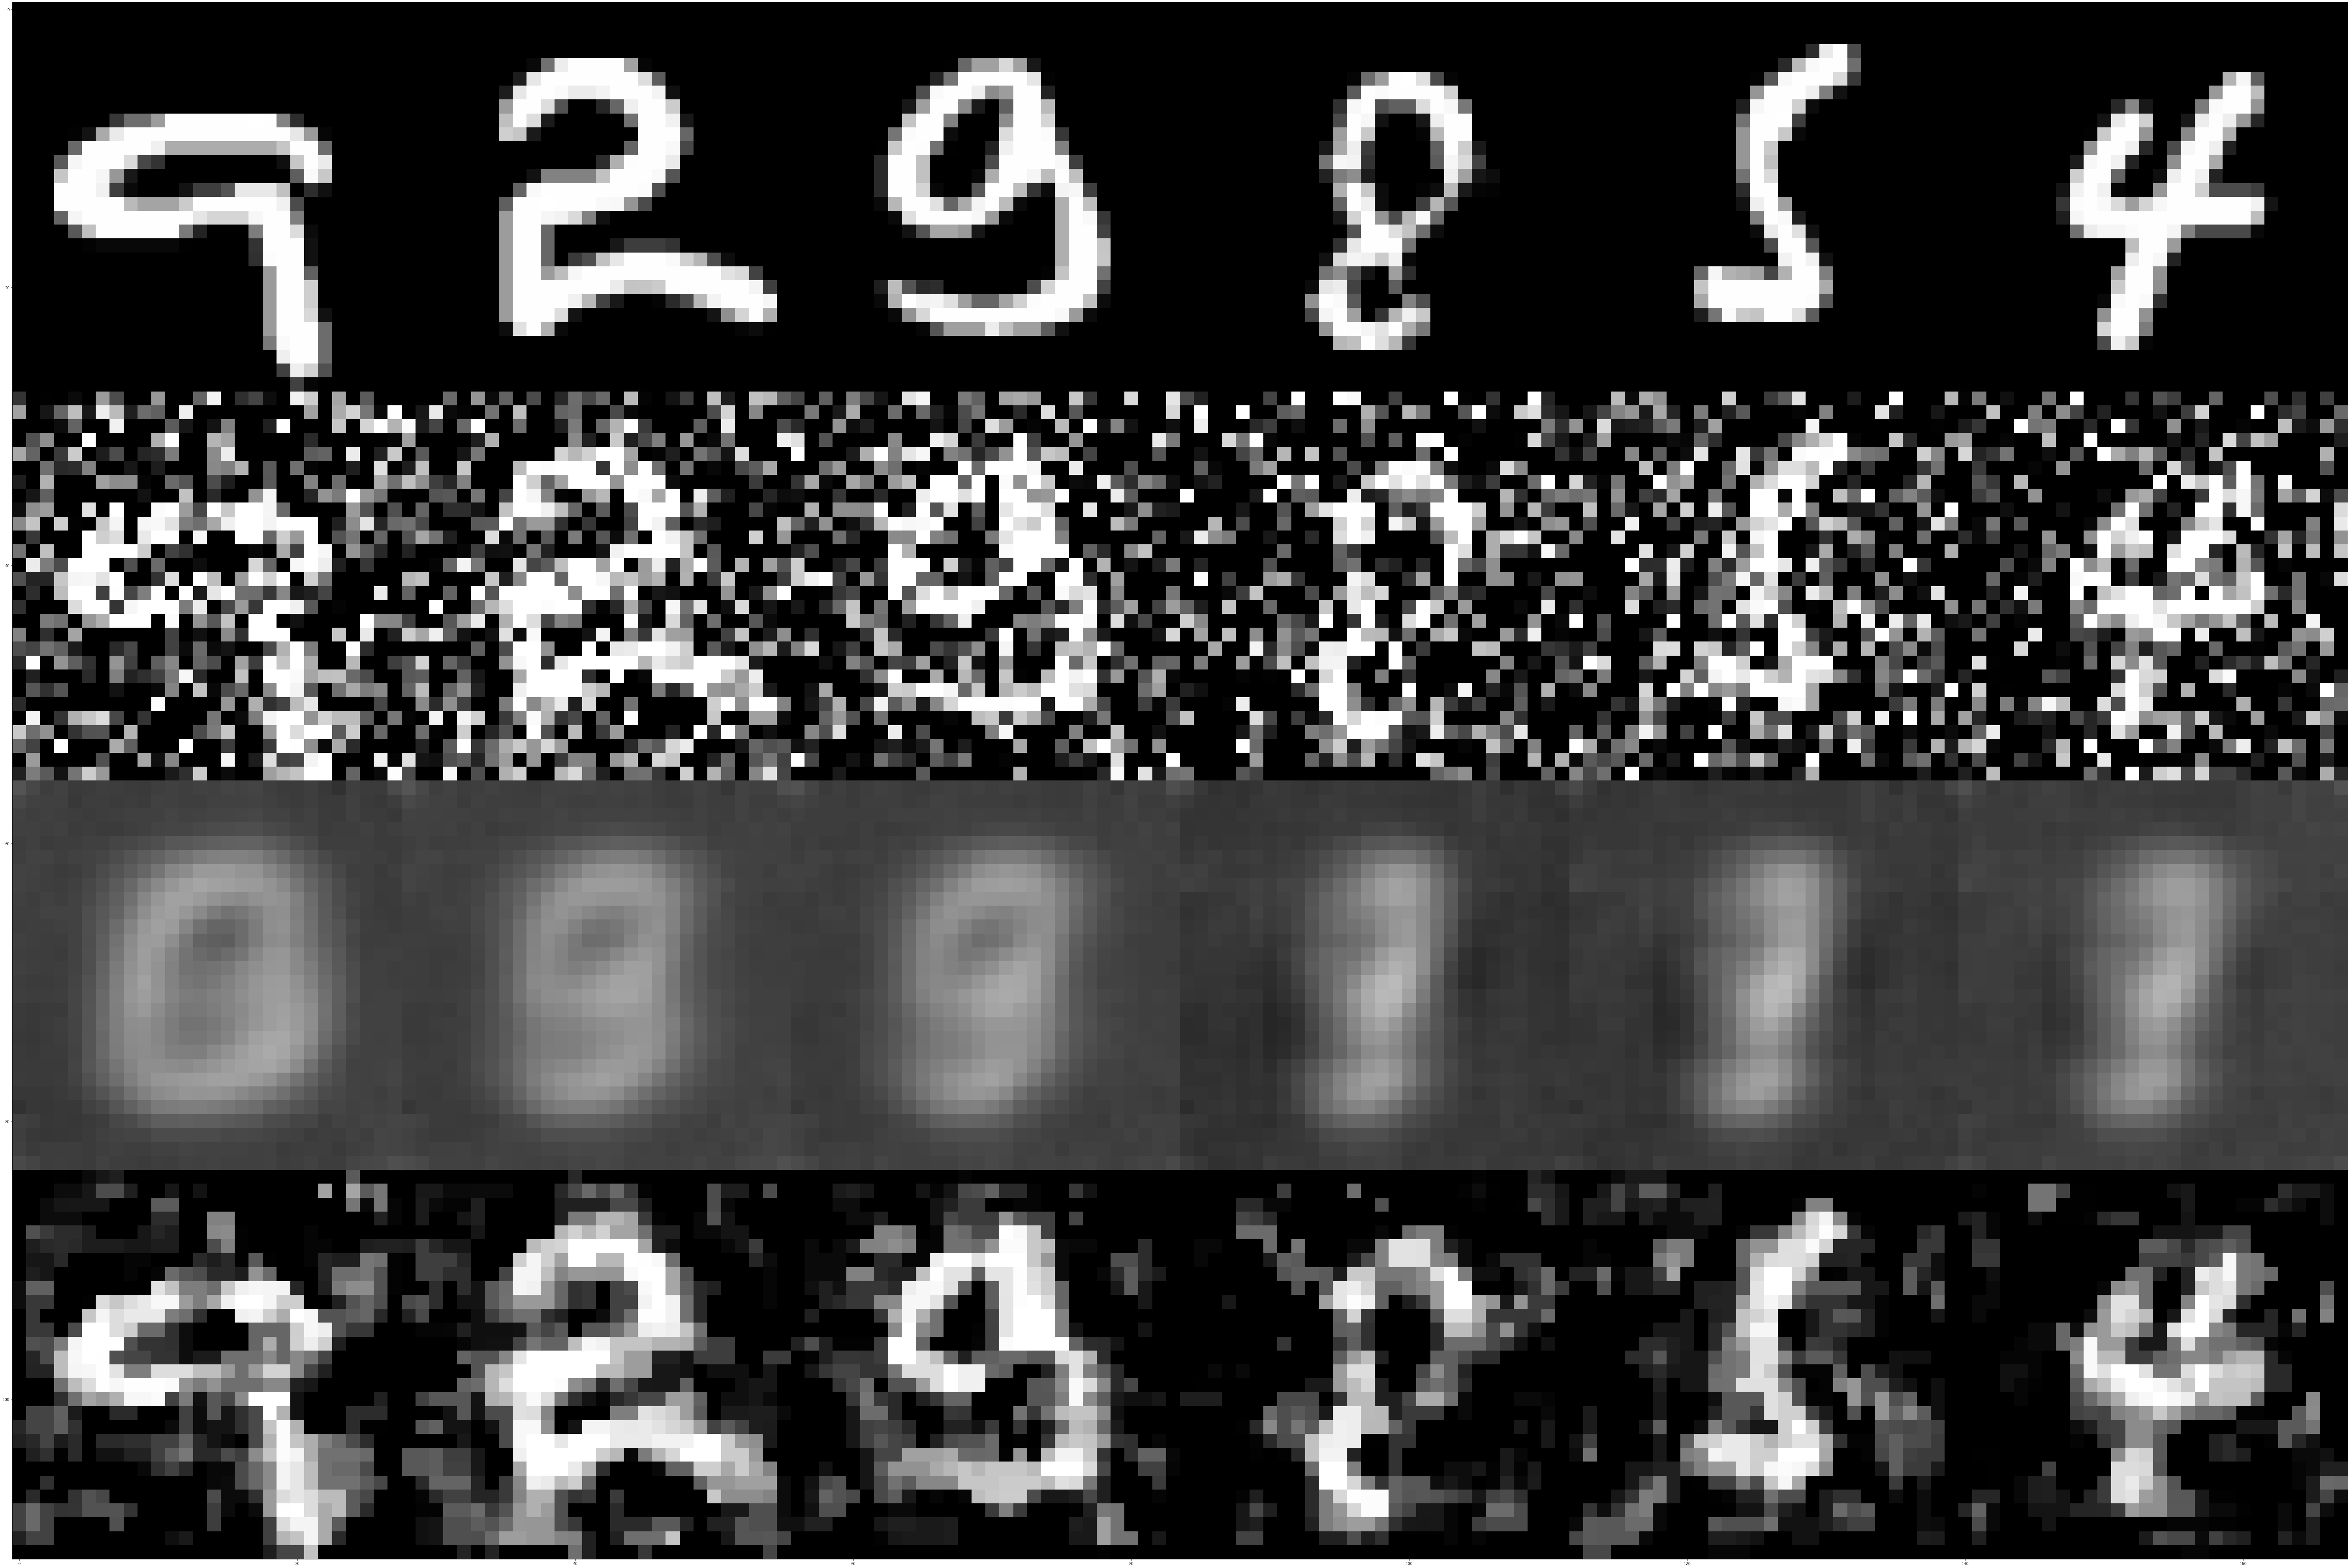

In [35]:
num_test=10000
showidx=np.random.randint(0,num_test,n_images)
x_out=vae.predict(x_test[showidx])
# Display
for i,idx in enumerate (showidx):
    figure[0: 28,i *28: (i + 1) * 28] = np.reshape(x_test[idx], [28, 28])
    figure[28: 28 * 2,i *28: (i + 1) * 28] = np.reshape(noise_test[idx], [28, 28])
    figure[28 * 2: 28 * 3,i *28: (i + 1) * 28] = np.reshape(x_out[i], [28, 28])
    figure[28 * 3: 28 * 4,i *28: (i + 1) * 28] = signal.medfilt2d(np.reshape(noise_test[idx], [28, 28]),[3,3])
plt.figure(figsize=(28 * 4, 28*n_images))
plt.imshow(figure, cmap='Greys_r')
plt.show()